# Implementação de algoritmo para usar as classes de simulação de array de microfones e GSC para o SESA Dataset

A ideia desse jupyter é criar um algoritmo que, dadas a pasta de origem e as de destino, simule um array de microfones com os áudios da pasta de origem e salve os sinais sem beamforming, com beamforming e com GSC nas pastas de destino.

In [1]:
import os
import librosa
import math
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio

#### Importando as classes criadas

In [2]:
import sys
sys.path.append('/home/dimi/Programming/IC2019/DOA/Python')

from GeneralizedSidelobeCancellerClass import GeneralizedSidelobeCanceller
from SimularArrayMicrofonesClass import SimularArrayMicrofones

## Definindo uma boa amplitude para o ruído

Pela definição, se a média do sinal for 0, pode-se aproximar a energia do sinal pela variância. A SNR pode ser definida como 10 * log_10 (var(sinal)/var(ruído)).

"Engineers consider a SNR of 2 (3 dB) to be the boundary between low and high SNRs".

http://www.scholarpedia.org/article/Signal-to-noise_ratio

In [3]:
def calcularSNR(sinal, ruido):
    return 10 * math.log((np.var(sinal)/np.var(ruido)), 10)

In [4]:
def calcularEnerigaRuidoDadoSNR(snrDesejada, energiaSinal):
    return energiaSinal/(10**(snrDesejada/10))

A função abaixo é exatamente a mesma que está sendo usada na classe SimularArrayMicrofones. Essa parte do jupyter vai servir apenas para achar uma boa SNR para realizar os testes.

In [5]:
def gerarRuidoBranco(qtdAmostras, energiaRuido):

    media        = 0
    desvioPadrao = 1

    return np.random.normal(media, desvioPadrao, size=qtdAmostras) * energiaRuido**(1/2)

O sinal que será aberto para fazer o teste **JÁ DEVE ESTAR NORMALIZADO PELA ENERGIA**, assim, fica muito mais fácil calcular a SNR.

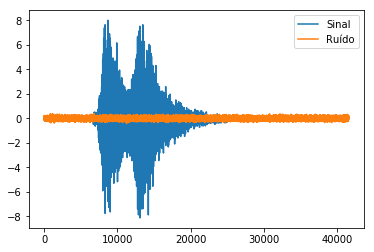

In [6]:
caminho = "/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/test/casual_000.wav"
sinalOriginal, freqAmostragem = librosa.load(caminho, sr=None, mono=True)

snrDesejada  = 20
energiaRuido = calcularEnerigaRuidoDadoSNR(snrDesejada, 1) 

ruido = gerarRuidoBranco(len(sinalOriginal), energiaRuido)

plt.plot(sinalOriginal, label="Sinal")
plt.plot(ruido, label="Ruído")
plt.legend()
plt.show()

In [7]:
print("Energia do sinal:", np.var(sinalOriginal))
print("Energia do ruído:", energiaRuido)
print("SNR:\t\t ", calcularSNR(sinalOriginal, ruido))

Energia do sinal: 0.9999998
Energia do ruído: 0.01
SNR:		  19.997053927958582


In [8]:
print("Original")
Audio(data=sinalOriginal, rate=freqAmostragem)

Original


In [9]:
print("Com ruído")
sinalComRuido = sinalOriginal + ruido
Audio(data=sinalComRuido, rate=freqAmostragem)

Com ruído


## Rodando o algoritmo para várias SNRs diferentes na pasta de teste do SESA

In [12]:
# DEFININDO PARAMETROS INICIAIS
pastaOrigem  = '/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/test/'
pastaDestino = '/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/outros/'

# LISTANDO OS ARQUIVOS NO DIRETORIO DE ORIGEM
arrayArquivos = os.listdir(pastaOrigem)
totalArquivos = len(arrayArquivos)

# CRIANDO UM ARRAY PARA GUARDAR O TEMPO MEDIO PARA PROCESSAR CADA ARQUIVO PARA CADA SNR DIFERENTE
arrayTempoGSCCadaSNR = []

# PARA VARIOS SNRs
for snrAtual in range(-1, -11, -1):
    
    print("\nINICIANDO A SIMULAÇÃO COM SNR", snrAtual)
    
    # TENHO QUE CRIAR A PASTA PARA ESSA SNR
    pastaDestinoSNRAtual = pastaDestino + "SNR_" + str(snrAtual) + "dB/"
    
    # SE ELA JA EXISTIR EU EXCLUO TUDO
    if os.path.isdir(pastaDestinoSNRAtual) == True:
        shutil.rmtree(pastaDestinoSNRAtual)
        print("Já havia uma pasta para os arquivos com essa SNR e portanto ela foi excluída")
        
    # AGORA SIM EU CRIO AS PASTAS E SUBPASTAS
    os.mkdir(pastaDestinoSNRAtual)
    os.mkdir(pastaDestinoSNRAtual + "testeSemBeamforming/")
    os.mkdir(pastaDestinoSNRAtual + "testeBeamforming/")
    os.mkdir(pastaDestinoSNRAtual + "testeGSC/")
    
    # PRECISO CALCULAR QUAL VAI SER A ENERGIA DO RUIDO PARA ESSA SNR
    energiaRuido = calcularEnerigaRuidoDadoSNR(snrAtual, 1)
    
    # ARRAY PARA GUARDAR O TEMPO PARA PROCESSAR O GSC DE CADA ARQUIVO
    arrayTempoGSCCadaArquivoSNRAtual = []
        
    # PARA CADA ARQUIVO NA PASTA DE ORIGEM
    for i, arquivoAtual in enumerate(arrayArquivos):

        print("\nArquivo " + str(i+1) + " de " + str(totalArquivos) + " -> " + str(100*((i+1)/totalArquivos)) + "%")

        # EU SIMULO UM ARRAY DE MICROFONES
        caminhoArquivo = pastaOrigem + arquivoAtual
        objSimularArrayMics = SimularArrayMicrofones(caminhoArquivo, energiaRuido)
        arraySinaisSimulados, arrayDelays, freqAmostragem = objSimularArrayMics.obterResultado()

        # APLICO O BEAMFORMING E GSC (SEM QUE A CLASSE SAIBA QUAIS SAO OS DELAYS)
        objGSC = GeneralizedSidelobeCanceller(arraySinaisSimulados)
        sinalSemBeamforming, sinalBeamformado, sinalFinalGSC = objGSC.obterSinaisResultantes()
        arrayTempoGSCCadaArquivoSNRAtual.append(objGSC.tempoProcessamentoGSC)

        # E POR FIM SALVO NAS PASTAS DE DESTINO
        librosa.output.write_wav(pastaDestinoSNRAtual + "testeSemBeamforming/" + arquivoAtual, sinalSemBeamforming, freqAmostragem)
        librosa.output.write_wav(pastaDestinoSNRAtual + "testeBeamforming/" + arquivoAtual, sinalBeamformado, freqAmostragem)
        librosa.output.write_wav(pastaDestinoSNRAtual + "testeGSC/" + arquivoAtual, sinalFinalGSC, freqAmostragem)
    
    # DEPOIS DE PROCESSAR TODOS OS ARQUIVOS PARA A SNR ATUAL, EU COLOCO O TEMPO DE PROCESSAMENTO MEDIO NO ARRAY DE TEMPOS DE CADA SNR
    mediaTempoGSCSNRAtual = np.mean(arrayTempoGSCCadaArquivoSNRAtual)
    arrayTempoGSCCadaSNR.append([snrAtual, mediaTempoGSCSNRAtual])
    print("\nTempo médio para processar o GSC em cada arquivo com SNR " + str(snrAtual) + ": " + str(mediaTempoGSCSNRAtual))
    
# DEPOIS QUE ACABAR TUDO, EU PRECISO SALVAR AS INFORMACOES DE TEMPO DE PROCESSAMENTO
dataframe = pd.DataFrame(data=arrayTempoGSCCadaSNR, columns=["SNR", "Tempo médio para processar o GSC em cada arquivo"])
dataframe.to_csv(pastaDestino + "tempoProcessamentoGSC" + str(time.time()) + ".csv", index=False)


INICIANDO A SIMULAÇÃO COM SNR -1

Arquivo 1 de 105 -> 0.9523809523809524%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.716503381729126

Arquivo 2 de 105 -> 1.9047619047619049%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.279879331588745

Arquivo 3 de 105 -> 2.857142857142857%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.0143580436706543

Arquivo 4 de 105 -> 3.8095238095238098%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.6432063579559326

Arquivo 5 de 105 -> 4.761904761904762%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC 

Tempo total gasto para processar o GSC completo (segundos): 3.6678242683410645

Arquivo 42 de 105 -> 40.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.7594165802001953

Arquivo 43 de 105 -> 40.95238095238095%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.3159046173095703

Arquivo 44 de 105 -> 41.904761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 115.40627861022949

Arquivo 45 de 105 -> 42.857142857142854%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 14.43032717704773

Arquivo 46 de 105 -> 43.80952380952381%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Te

Tempo total gasto para processar o GSC completo (segundos): 0.653130292892456

Arquivo 83 de 105 -> 79.04761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.772505521774292

Arquivo 84 de 105 -> 80.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 21.785396575927734

Arquivo 85 de 105 -> 80.95238095238095%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 4.6035566329956055

Arquivo 86 de 105 -> 81.9047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.27936625480651855

Arquivo 87 de 105 -> 82.85714285714286%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo

Tempo total gasto para processar o GSC completo (segundos): 1.3062357902526855

Arquivo 19 de 105 -> 18.095238095238095%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.8068492412567139

Arquivo 20 de 105 -> 19.047619047619047%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.7026052474975586

Arquivo 21 de 105 -> 20.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.249394416809082

Arquivo 22 de 105 -> 20.952380952380953%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 8.192649602890015

Arquivo 23 de 105 -> 21.904761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
T

Tempo total gasto para processar o GSC completo (segundos): 0.6966109275817871

Arquivo 60 de 105 -> 57.14285714285714%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.4745316505432129

Arquivo 61 de 105 -> 58.0952380952381%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 3.2247798442840576

Arquivo 62 de 105 -> 59.04761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.501011848449707

Arquivo 63 de 105 -> 60.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.648517370223999

Arquivo 64 de 105 -> 60.952380952380956%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo

Tempo total gasto para processar o GSC completo (segundos): 1.8490288257598877

Arquivo 101 de 105 -> 96.19047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.2553091049194336

Arquivo 102 de 105 -> 97.14285714285714%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.4387061595916748

Arquivo 103 de 105 -> 98.09523809523809%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.282414197921753

Arquivo 104 de 105 -> 99.04761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.1033046245574951

Arquivo 105 de 105 -> 100.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LM

Tempo total gasto para processar o GSC completo (segundos): 0.6380250453948975

Arquivo 37 de 105 -> 35.23809523809524%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.9396400451660156

Arquivo 38 de 105 -> 36.19047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5175046920776367

Arquivo 39 de 105 -> 37.142857142857146%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.8032810688018799

Arquivo 40 de 105 -> 38.095238095238095%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5337080955505371

Arquivo 41 de 105 -> 39.04761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptat

Tempo total gasto para processar o GSC completo (segundos): 7.5768516063690186

Arquivo 78 de 105 -> 74.28571428571429%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 4.792325496673584

Arquivo 79 de 105 -> 75.23809523809524%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.7557995319366455

Arquivo 80 de 105 -> 76.19047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.1241116523742676

Arquivo 81 de 105 -> 77.14285714285715%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.8809072971343994

Arquivo 82 de 105 -> 78.0952380952381%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa 

Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.1693859100341797

Arquivo 14 de 105 -> 13.333333333333334%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.936164140701294

Arquivo 15 de 105 -> 14.285714285714285%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.5697600841522217

Arquivo 16 de 105 -> 15.238095238095239%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.8909029960632324

Arquivo 17 de 105 -> 16.19047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.0807397365570068

Arquivo 18 de 105 -> 17.142857142857142%
Calculando os delays entre o

Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.3827757835388184

Arquivo 55 de 105 -> 52.38095238095239%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5018343925476074

Arquivo 56 de 105 -> 53.333333333333336%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.837045907974243

Arquivo 57 de 105 -> 54.285714285714285%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.4266607761383057

Arquivo 58 de 105 -> 55.23809523809524%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.8340842723846436

Arquivo 59 de 105 -> 56.19047619047619%
Calculando os delays entre os 

Tempo total gasto para processar o GSC completo (segundos): 14.661375761032104

Arquivo 96 de 105 -> 91.42857142857143%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.7398924827575684

Arquivo 97 de 105 -> 92.38095238095238%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.1582679748535156

Arquivo 98 de 105 -> 93.33333333333333%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.898155689239502

Arquivo 99 de 105 -> 94.28571428571428%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 3.225224733352661

Arquivo 100 de 105 -> 95.23809523809523%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa

Tempo total gasto para processar o GSC completo (segundos): 0.5441615581512451

Arquivo 32 de 105 -> 30.476190476190478%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 78.29811477661133

Arquivo 33 de 105 -> 31.428571428571427%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 4.1662514209747314

Arquivo 34 de 105 -> 32.38095238095238%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.887253761291504

Arquivo 35 de 105 -> 33.33333333333333%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.8887510299682617

Arquivo 36 de 105 -> 34.285714285714285%
Calculando os delays entre os microfones
Iniciando a filtragem adaptati

Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 12.538235664367676

Arquivo 73 de 105 -> 69.52380952380952%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.2261977195739746

Arquivo 74 de 105 -> 70.47619047619048%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.8699488639831543

Arquivo 75 de 105 -> 71.42857142857143%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.2378203868865967

Arquivo 76 de 105 -> 72.38095238095238%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.4416935443878174

Arquivo 77 de 105 -> 73.33333333333333%
Calculando os delays entre os m

Tempo total gasto para processar o GSC completo (segundos): 1.7912328243255615

Arquivo 8 de 105 -> 7.6190476190476195%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.6952002048492432

Arquivo 9 de 105 -> 8.571428571428571%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.3911561965942383

Arquivo 10 de 105 -> 9.523809523809524%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.6890444755554199

Arquivo 11 de 105 -> 10.476190476190476%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.6561980247497559

Arquivo 12 de 105 -> 11.428571428571429%
Calculando os delays entre os microfones
Iniciando a filtragem adaptati

Tempo total gasto para processar o GSC completo (segundos): 1.0077030658721924

Arquivo 49 de 105 -> 46.666666666666664%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 4.861185312271118

Arquivo 50 de 105 -> 47.61904761904761%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 6.807500600814819

Arquivo 51 de 105 -> 48.57142857142857%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.9941260814666748

Arquivo 52 de 105 -> 49.523809523809526%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.2027902603149414

Arquivo 53 de 105 -> 50.476190476190474%
Calculando os delays entre os microfones
Iniciando a filtragem adaptati

Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 3.0013785362243652

Arquivo 90 de 105 -> 85.71428571428571%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 26.06033492088318

Arquivo 91 de 105 -> 86.66666666666667%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 4.072789430618286

Arquivo 92 de 105 -> 87.61904761904762%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.507652759552002

Arquivo 93 de 105 -> 88.57142857142857%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.5005691051483154

Arquivo 94 de 105 -> 89.52380952380953%
Calculando os delays entre os micr

Tempo total gasto para processar o GSC completo (segundos): 0.5376155376434326

Arquivo 25 de 105 -> 23.809523809523807%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 21.089411735534668

Arquivo 26 de 105 -> 24.761904761904763%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.4148385524749756

Arquivo 27 de 105 -> 25.71428571428571%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 7.091296195983887

Arquivo 28 de 105 -> 26.666666666666668%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 15.101015329360962

Arquivo 29 de 105 -> 27.61904761904762%
Calculando os delays entre os microfones
Iniciando a filtragem adaptat

Tempo total gasto para processar o GSC completo (segundos): 0.3261294364929199

Arquivo 66 de 105 -> 62.857142857142854%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5109684467315674

Arquivo 67 de 105 -> 63.8095238095238%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5302338600158691

Arquivo 68 de 105 -> 64.76190476190476%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.9644901752471924

Arquivo 69 de 105 -> 65.71428571428571%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.872469186782837

Arquivo 70 de 105 -> 66.66666666666666%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa

Tempo total gasto para processar o GSC completo (segundos): 0.7947859764099121

Arquivo 2 de 105 -> 1.9047619047619049%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.3869907855987549

Arquivo 3 de 105 -> 2.857142857142857%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.1444108486175537

Arquivo 4 de 105 -> 3.8095238095238098%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.089026927947998

Arquivo 5 de 105 -> 4.761904761904762%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.9901688098907471

Arquivo 6 de 105 -> 5.714285714285714%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa co

Tempo total gasto para processar o GSC completo (segundos): 0.46634507179260254

Arquivo 43 de 105 -> 40.95238095238095%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 8.954479694366455

Arquivo 44 de 105 -> 41.904761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 111.96802234649658

Arquivo 45 de 105 -> 42.857142857142854%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 14.236600160598755

Arquivo 46 de 105 -> 43.80952380952381%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.2864367961883545

Arquivo 47 de 105 -> 44.761904761904766%
Calculando os delays entre os microfones
Iniciando a filtragem adapta

Tempo total gasto para processar o GSC completo (segundos): 0.7749781608581543

Arquivo 84 de 105 -> 80.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 3.0962953567504883

Arquivo 85 de 105 -> 80.95238095238095%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 6.668250799179077

Arquivo 86 de 105 -> 81.9047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.3080410957336426

Arquivo 87 de 105 -> 82.85714285714286%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 67.95052289962769

Arquivo 88 de 105 -> 83.80952380952381%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo 

Tempo total gasto para processar o GSC completo (segundos): 0.9876947402954102

Arquivo 20 de 105 -> 19.047619047619047%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.6810290813446045

Arquivo 21 de 105 -> 20.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.0551555156707764

Arquivo 22 de 105 -> 20.952380952380953%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 6.688021659851074

Arquivo 23 de 105 -> 21.904761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.729663848876953

Arquivo 24 de 105 -> 22.857142857142858%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
T

Tempo total gasto para processar o GSC completo (segundos): 0.7172272205352783

Arquivo 61 de 105 -> 58.0952380952381%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.9175314903259277

Arquivo 62 de 105 -> 59.04761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.558922290802002

Arquivo 63 de 105 -> 60.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5992205142974854

Arquivo 64 de 105 -> 60.952380952380956%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.186370611190796

Arquivo 65 de 105 -> 61.904761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Temp

Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.7653415203094482

Arquivo 102 de 105 -> 97.14285714285714%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 16.088184118270874

Arquivo 103 de 105 -> 98.09523809523809%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.5913114547729492

Arquivo 104 de 105 -> 99.04761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.8747432231903076

Arquivo 105 de 105 -> 100.0%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5893607139587402

Tempo médio para processar o GSC em cada arquivo com SNR -9: 4.270162039711362


Tempo total gasto para processar o GSC completo (segundos): 2.3818750381469727

Arquivo 37 de 105 -> 35.23809523809524%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 2.0475571155548096

Arquivo 38 de 105 -> 36.19047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 1.3227348327636719

Arquivo 39 de 105 -> 37.142857142857146%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5181338787078857

Arquivo 40 de 105 -> 38.095238095238095%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 4.00197696685791

Arquivo 41 de 105 -> 39.04761904761905%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativ

Tempo total gasto para processar o GSC completo (segundos): 0.6076960563659668

Arquivo 78 de 105 -> 74.28571428571429%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 5.432972192764282

Arquivo 79 de 105 -> 75.23809523809524%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.5984883308410645

Arquivo 80 de 105 -> 76.19047619047619%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.6870696544647217

Arquivo 81 de 105 -> 77.14285714285715%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa com LMS
Tempo total gasto para processar o GSC completo (segundos): 0.3508176803588867

Arquivo 82 de 105 -> 78.0952380952381%
Calculando os delays entre os microfones
Iniciando a filtragem adaptativa 